O que é <b>BERT</b>?

<b>BERT</b> significa <b>B</b>idirectional <b>E</b>ncoder <b>R</b>epresentations from <b>T</b>ransformers.

<b>Bidirecional</b> - para entender o texto que estamos procurando, temos de olhar para trás (nas palavras anteriores) e para a frente (nas próximas palavras)

<b>Transformers</b> - O mecanismo de Atenção é tudo que precisamos. O Transformer lê sequências inteiras de tokens de uma vez. Em certo sentido, o modelo é não direcional, enquanto os LSTMs leem sequencialmente (da esquerda para a direita ou da direita para a esquerda). O mecanismo de atenção permite o aprendizado de relações contextuais entre palavras.

<b>Embeddings</b> de palavras contextualizadas (pré-treinadas) - O artigo ELMO apresentou uma maneira de codificar palavras com base em seu significado / contexto.

O BERT foi treinado mascarando 15% dos tokens com o objetivo de adivinhá-los. Um objetivo adicional era prever a próxima frase.

BERT é simplesmente uma stack pré-treinada de Transformer Encoders com duas versões 
- com 12 (BERT base) 
- com 24 (BERT Large).

A BERT pode ser utilizada em inúmeras tasks do NLP, aqui <b>tentaremos</b> utilizar para classificar se, dadas duas entidades e a sentença a qual elas pertencem, há uma relação semântica entre elas.

In [ ]:
#Trecho para ser executado quando no Sagemaker
!pip install transformers==3.3.1
#!pip install torch==1.6.0
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

     |████████████████████████████████| 1.1MB 16.6MB/s 
     |████████████████████████████████| 890kB 49.7MB/s 
     |████████████████████████████████| 3.0MB 40.9MB/s 
     |████████████████████████████████| 1.2MB 50.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=a35aa60e62ee198cbb07af4a81c89e24a663f71a136bfa26f1ade31b49b241c6
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 708.0MB 25kB/s 
     |████████████████████████████████| 5.9MB 46.4MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


Importando as bibliotecas necessárias para rodar o modelo

In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import os

In [ ]:
torch.cuda.is_available()

True

Setando alguns parametros básicos

In [ ]:
#Configurando parametros para visualização de dados
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
class_names = ['negativa', 'positiva']

#Configuração de SEED 
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

#Flag para utilizar cuda quando presente uma GPU ou utilizar CPU
print(torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

True
cuda:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Capturando os dados

In [ ]:
file_path = "/content/drive/My Drive/data_full.csv"

data = pd.read_csv(file_path, sep=';').replace({np.NaN: None})
data.columns = ['sentenca','entidade1','entidade1_tipo','relacao','entidade2','entidade2_tipo']

cols = ['entidade1', 'entidade2']
data['entidades'] = data[cols].apply(lambda row: ' , '.join(row.values.astype(str)), axis=1)

data['class'] = data['relacao'].apply(lambda x: 0 if x is None else 1)

data.head()

,sentenca,entidade1,entidade1_tipo,relacao,entidade2,entidade2_tipo,entidades,class
0,World Alliance of Reformed Churches condena a ...,Iraque,LOC,condena a guerra no,World Alliance of,ORG,"Iraque , World Alliance of",1
1,Em 19 de Dezembro de 1974 foi assinado um acor...,PAIGC,ORG,acordo entre,Portugal,LOC,"PAIGC , Portugal",1
2,Em 19 de Dezembro de 1974 foi assinado um acor...,PAIGC,ORG,None,Cabo Verde,LOC,"PAIGC , Cabo Verde",0
3,Em 19 de Dezembro de 1974 foi assinado um acor...,Portugal,LOC,None,Cabo Verde,LOC,"Portugal , Cabo Verde",0
4,"A 88i , plataforma de serviços digitais para s...",88i,ORG,foi aprovada no,Global Startup Program,ORG,"88i , Global Startup Program",1


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3288 entries, 0 to 3287
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   sentenca        3288 non-null   object
 1   entidade1       3288 non-null   object
 2   entidade1_tipo  3286 non-null   object
 3   relacao         1485 non-null   object
 4   entidade2       3288 non-null   object
 5   entidade2_tipo  3286 non-null   object
 6   entidades       3288 non-null   object
 7   class           3288 non-null   int64 
dtypes: int64(1), object(7)
memory usage: 205.6+ KB


Verificando como o dataset está populado.
Não informações nulas nos campos de Sentença, Entidade 1, Entidade 2 e Class

In [ ]:
#NUM_AMOSTRA = None

# Deixando o dataset inicial balanceado
# - Se for um teste aleatório somente com uma amostragem de dados, vai pegar essa quantidade e dividir 
# ao meio para pegar 50% de cada classe
# - Se for um teste com todo o dataset, pega a quantidade de registros da classe minoritária

#if NUM_AMOSTRA is not None:
#    data_positivo = data[data['class']==1]
#    print(data_positivo.shape)

#    data_negativo = data[data['class']==0]
#    print(data_negativo.shape)
    
#    data = data_positivo.head(int(NUM_AMOSTRA/2)).append(data_negativo.head(int(NUM_AMOSTRA/2)))
#else:
#    data_positivo = data[data['class']==1]
#    print(data_positivo.shape)

#    data_negativo = data[data['class']==0]
#    print(data_negativo.shape)
    
#    MIN_AMOSTRA = min(data_negativo.shape[0], data_positivo.shape[0])
#    print(MIN_AMOSTRA)
#    data = data_positivo.head(int(MIN_AMOSTRA)).append(data_negativo.head(int(MIN_AMOSTRA)))

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3288 entries, 0 to 3287
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   sentenca        3288 non-null   object
 1   entidade1       3288 non-null   object
 2   entidade1_tipo  3286 non-null   object
 3   relacao         1485 non-null   object
 4   entidade2       3288 non-null   object
 5   entidade2_tipo  3286 non-null   object
 6   entidades       3288 non-null   object
 7   class           3288 non-null   int64 
dtypes: int64(1), object(7)
memory usage: 205.6+ KB


Verificando o balanceamento de classes

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


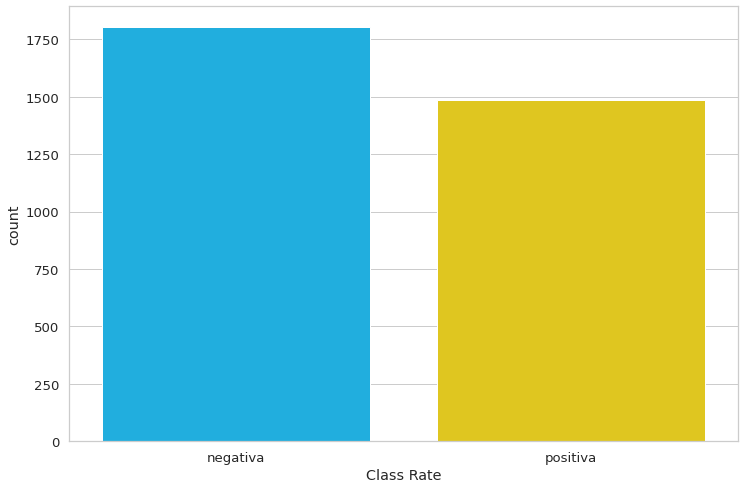

In [ ]:
ax = sns.countplot(data['class'])
plt.xlabel('Class Rate')
ax.set_xticklabels(class_names);

<h2>Pre-Processamento</h2>

É preciso converter texto em números. 
O BERT exige ainda mais atenção. Dessa maneira:

- Adicionaremos tokens especiais para separar frases e fazer a classificação
- Passaremos sequências de comprimento constante (introduzir preenchimento)
- Criaremos uma matriz de 0s (token de teclado) e 1s (token real) chamada máscara de atenção
- A biblioteca Transformers fornece vários modelos de Transformers (incluindo BERT). Funciona com TensorFlow e PyTorch! Também inclui tokenizers pré-construídos que fazem o trabalho pesado para nós!

Carregando o tokenizador pre-treinado da BERT

In [ ]:
# PRE_TRAINED_MODEL_NAME = '/root/.cache/torch/transformers/neuralmind-bert-large-portuguese-cased/'
PRE_TRAINED_MODEL_NAME = 'neuralmind/bert-large-portuguese-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Entendendo o que faz o tokenizador, pegando apenas uma sentença do corpus inteiro.

In [ ]:
sentenca_amostra = data['sentenca'].iloc[100]
tokens = tokenizer.tokenize(sentenca_amostra)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f'- Sentença: {sentenca_amostra}')
print(f'- Tokens: {tokens}')
print(f'- Token IDs: {token_ids}')

- Sentença: A Decolar , maior agência de viagens online da América Latina , fez uma parceria com o banco Santander Brasil para a emissão de um cartão de crédito com serviços e benefícios para o turista .
- Tokens: ['A', 'Dec', '##olar', ',', 'maior', 'agência', 'de', 'viagens', 'online', 'da', 'América', 'Latina', ',', 'fez', 'uma', 'parceria', 'com', 'o', 'banco', 'Santa', '##nder', 'Brasil', 'para', 'a', 'emissão', 'de', 'um', 'cartão', 'de', 'crédito', 'com', 'serviços', 'e', 'benefícios', 'para', 'o', 'tur', '##ista', '.']
- Token IDs: [177, 4534, 10432, 117, 636, 9012, 125, 7348, 9700, 180, 2094, 6232, 117, 1191, 230, 4495, 170, 146, 6465, 1838, 1217, 771, 221, 123, 11352, 125, 222, 12807, 125, 10640, 170, 2654, 122, 10412, 221, 146, 1356, 384, 119]


<h2> Tokens Especiais </h2>

[SEP] - Token que marca o fim da sentença.
('[SEP]', 102)

[CLS] - Token que marca o início da sentença.
('[CLS]', 101)

[PAD] - Token para preenchimento da sentença para que todas fiquem em um cumprimento fixo.
('[PAD]', 0)

[UNK] - Token para todos os tokens que a BERT desconhece
('[UNK]', 100)

<h2>Estabelecendo o comprimento da sentença</h2>

O BERT trabalha com sequências de comprimento fixo. 
Vamos armazenar o comprimento do token de cada avaliação e capturar o comprimento máximo

In [ ]:
token_lens = []
for txt in data.sentenca:
    tokens = tokenizer.encode(txt, max_length=512, truncation= True)
    token_lens.append(len(tokens))
    if len(tokens) > 170:
        print(txt)
    
MAX_LENGHT = max(token_lens)
print(MAX_LENGHT)

102


<h2>Estabelecendo o comprimento do maior par de entidades</h2>

O BERT trabalha com sequências de comprimento fixo. 
Vamos armazenar o comprimento do token de cada par de sentença e capturar o comprimento máximo


In [ ]:
entities_token_lens = []
for txt in data.entidades:
    tokens = tokenizer.encode(txt, max_length=512, truncation= True)
    entities_token_lens.append(len(tokens))
    if len(tokens) > 20:
        print(txt)
    
MAX_ENTITIES_LENGHT = max(entities_token_lens)
print(MAX_ENTITIES_LENGHT)

Datafolha , Associação Brasileira das Entidades dos Mercados Financeiro e de Capitais
Raio X , Associação Brasileira das Entidades dos Mercados Financeiro e de Capitais
Feira de Ciências e Cultura da Escola Fortec , São Vicente Feira de Ciências e Cultura da Escola Fortec
Fórum de Inovação Agropecuário , Ministério da Agricultura , Pecuária e Abastecimento
Startup Weekend Blockchain Techstars , banco Barclays da Inglaterra
Samsung Creative Startups , Centro Coreano de Economia Criativa e Inovação
Samsung Creative Startups , Associação Nacional de Entidades Promotoras de Empreendimentos Inovadores
Centro Coreano de Economia Criativa e Inovação , Associação Nacional de Entidades Promotoras de Empreendimentos Inovadores
Micro , Pequenas e Médias Empresas da Serasa Experian , Victor Loyola
Bradesco , Efma-Accenture Distribution & Marketing Innovation Award 2018
MRV Sustentabilidade , Inovação e Mobilidade , Salão do Automóvel de São Paulo
Centro Coreano de Economia Criativa e Inovação , As

Histograma dos tokens

para visualizar a distribuição das sentenças em relação a distribuição dos tokens.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


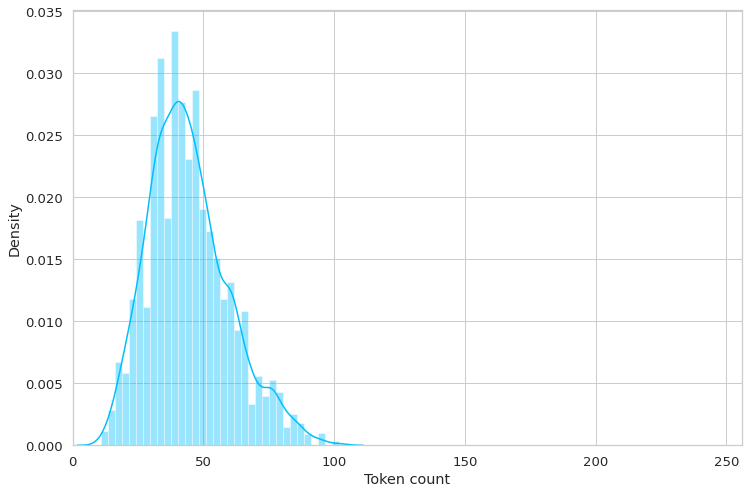

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

<h2>Classe de pré-processamento</h2>
    
Temos todos os blocos de construção necessários para criar um conjunto de dados PyTorch. Isso será feito a partir de uma classe estabelecida abaixo.

O tokenizer está fazendo a maior parte do trabalho. Também devolve a sentença que foi classificada, para que seja mais fácil avaliar as previsões do modelo. 

In [ ]:
class preProccesDataset(Dataset):
    
    def __init__(self, sentence, entity1, entity2, entities, targets, tokenizer, max_len, max_len_entities):
        self.sentence = sentence
        self.entity1 = entity1
        self.entity2 = entity2
        self.entities = entities
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.max_len_entities = max_len_entities
    
    def __len__(self):
        return len(self.sentence)
    
    def __getitem__(self, item):
        #inputs = [str(self.sentence[item]), str(self.entity1[item]), str(self.entity2[item])]
        inputs = [str(self.sentence[item])]
        target = self.targets[item]
        # Encodamos todas as entradas
        encoding = [
                    self.tokenizer.encode_plus(
                        x,
                        add_special_tokens=True,
                        max_length=self.max_len,
                        return_token_type_ids=True,
                        padding='max_length',
                        return_attention_mask=True,
                        return_tensors='pt',
                        truncation=True
                    )
                  for x in inputs
        ]

        entities_inputs = [str(self.entities[item])]
        entities_encoding = [
                             self.tokenizer.encode_plus(
                                 x,
                                 add_special_tokens=True,
                                 max_length=self.max_len_entities,
                                 return_token_type_ids=True,
                                 padding='max_length',
                                 return_attention_mask=True,
                                 return_tensors='pt',
                                 truncation=True
                              )
                             for x in entities_inputs
        ]

        # Contatenamos os ids e attention_masks das sentencas e entidades\n",
        input_ids = torch.cat(tuple(x['input_ids'].flatten() for x in encoding), dim=0)
        attention_mask = torch.cat(tuple(x['attention_mask'].flatten() for x in encoding), dim=0)

        input_entities_ids = torch.cat(tuple(x['input_ids'].flatten() for x in entities_encoding), dim=0)
        attention_entities_mask = torch.cat(tuple(x['attention_mask'].flatten() for x in entities_encoding), dim=0)
        
        return {
          'input_text': inputs,
          'input_ids': input_ids,
          'attention_mask': attention_mask,
          'targets': torch.tensor(target, dtype=torch.long),
          'input_entities_text': entities_inputs,
          'input_entities_ids': input_entities_ids,
          'attention_entities_mask': attention_entities_mask
        }

<h2>Separação dos dados</h2>
Treino, Teste e Validação

Dividindo os dados entre treino (x%) e teste (y%), onde x+y = 100

Em seguida, divide os dados de teste entre teste (x%) e validação (y%), onde x+y = 100

Na função de separação dos dados foi configurado o parâmetro de <b>stratify</b>, para que possamos separar os dados respeitando a distribuição das classes

In [ ]:
df_train, df_test = train_test_split(
  data,
  test_size=0.2,
  random_state=RANDOM_SEED,
  stratify = data['class']
)

df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED,
  stratify = df_test['class']
)

df_train.shape, df_test.shape, df_val.shape

((2630, 8), (329, 8), (329, 8))

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2630 entries, 1834 to 1586
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   sentenca        2630 non-null   object
 1   entidade1       2630 non-null   object
 2   entidade1_tipo  2628 non-null   object
 3   relacao         1188 non-null   object
 4   entidade2       2630 non-null   object
 5   entidade2_tipo  2628 non-null   object
 6   entidades       2630 non-null   object
 7   class           2630 non-null   int64 
dtypes: int64(1), object(7)
memory usage: 184.9+ KB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 329 entries, 2858 to 3039
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   sentenca        329 non-null    object
 1   entidade1       329 non-null    object
 2   entidade1_tipo  329 non-null    object
 3   relacao         148 non-null    object
 4   entidade2       329 non-null    object
 5   entidade2_tipo  329 non-null    object
 6   entidades       329 non-null    object
 7   class           329 non-null    int64 
dtypes: int64(1), object(7)
memory usage: 23.1+ KB


In [ ]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 329 entries, 1455 to 2406
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   sentenca        329 non-null    object
 1   entidade1       329 non-null    object
 2   entidade1_tipo  329 non-null    object
 3   relacao         149 non-null    object
 4   entidade2       329 non-null    object
 5   entidade2_tipo  329 non-null    object
 6   entidades       329 non-null    object
 7   class           329 non-null    int64 
dtypes: int64(1), object(7)
memory usage: 23.1+ KB


<h2>Data Loader </h2>
Função que auxilia na criação dos dataloaders dos dados utilizando a classe recém criada de processamento de sentenças.

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size, max_len_entities):
    ds = preProccesDataset(
        sentence=df['sentenca'].to_numpy(),
        entity1=df['entidade1'].to_numpy(),
        entity2=df['entidade2'].to_numpy(),
        entities=df['entidades'].to_numpy(),
        targets=df['class'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len,
        max_len_entities=max_len_entities
  )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
  )

Criando os data loaders para cada função de dataset

In [ ]:
BATCH_SIZE = 16

In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LENGHT, BATCH_SIZE, MAX_ENTITIES_LENGHT)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LENGHT, BATCH_SIZE, MAX_ENTITIES_LENGHT)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LENGHT, BATCH_SIZE, MAX_ENTITIES_LENGHT)

Exemplo do data loader de treinamento:

In [ ]:
df = next(iter(train_data_loader))
print(df.keys())

print(df['input_ids'].shape)
print(df['attention_mask'].shape)
print(df['input_entities_ids'].shape)
print(df['attention_entities_mask'].shape)
print(df['targets'].shape)

dict_keys(['input_text', 'input_ids', 'attention_mask', 'targets', 'input_entities_text', 'input_entities_ids', 'attention_entities_mask'])
torch.Size([16, 102])
torch.Size([16, 102])
torch.Size([16, 29])
torch.Size([16, 29])
torch.Size([16])


In [ ]:
x = next(iter(train_data_loader))
x

{'attention_entities_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
 

<h2>Modelo Classificador</h2>

Criando um classificador que use o modelo <b>BERT</b>:

O classificador delega a maior parte do trabalho pesado para o BertModel. Usamos uma camada de eliminação para alguma regularização e uma camada totalmente conectada para nossa saída. 

Retorna a saída bruta da última camada, pois isso é necessário para que a função de perda de entropia cruzada em PyTorch funcione.

In [ ]:
class ModeloVerificaRelacao(nn.Module):
    
    def __init__(self, n_classes, bert_embedding_model, hidden_size, dropout_prob=0.2):
        
        super(ModeloVerificaRelacao, self).__init__()
        self._drop_prob = dropout_prob
        
        self.bert_sentenca = bert_embedding_model if bert_embedding_model is not None else BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,num_labels=n_classes)
        self.bert_entity = bert_embedding_model if bert_embedding_model is not None else BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,num_labels=n_classes)

        self.out = nn.Sequential(
            #nn.Dropout(self._drop_prob),
            nn.Linear(self.bert_sentenca.config.hidden_size+self.bert_entity.config.hidden_size, n_classes)
        )
        
    def forward(self, input_ids, attention_mask, input_entities_ids, attention_entities_mask):
        last_hidden_state_sentence, pooled_output_sentence = self.bert_sentenca(input_ids=input_ids,attention_mask=attention_mask) 
        last_hidden_state_entities, pooled_output_entities = self.bert_entity(input_ids=input_entities_ids,attention_mask=attention_entities_mask) 

        pooled_output = torch.cat((pooled_output_sentence, pooled_output_entities), 1)
        m=nn.Sigmoid()
        return m(self.out(pooled_output))
        #return self.out(pooled_output)

Criando uma instância e movê-la para a GPU <b>(caso tenha)</b>

In [ ]:
NUM_CLASSES = len(class_names)
print(f"Suggest using {NUM_CLASSES} classes")
NUM_CLASSES=1
print(f"Using {NUM_CLASSES} classes")

Suggest using 2 classes
Using 1 classes


In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,num_labels=NUM_CLASSES)

In [ ]:
model = ModeloVerificaRelacao(n_classes=NUM_CLASSES, bert_embedding_model=bert_model, hidden_size=512, dropout_prob=0.2)

Lote de exemplo de nossos dados de treinamento movido para a GPU:

In [ ]:
input_ids = df['input_ids'].to(device)
attention_mask = df['attention_mask'].to(device)
print(input_ids.shape) 
print(attention_mask.shape) 

input_entities_ids = df['input_entities_ids'].to(device)
attention_entities_mask = df['attention_entities_mask'].to(device)
print(input_entities_ids.shape) 
print(attention_entities_mask.shape) 


torch.Size([16, 102])
torch.Size([16, 102])
torch.Size([16, 29])
torch.Size([16, 29])


# Treinamento

## Definição dos metodos de treinamento

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples, verbose=False):
    model = model.to(device)
    model = model.train()
    losses = []
    correct_predictions = 0
    
    counter = 0
    data_count = len(data_loader)
    
    for d in data_loader:
        counter += 1

        if verbose:
          if counter % 50 == 0:
            print("Performing step {" + str(counter) + "} out of a total of {" + str(data_count) + "} steps...")
        
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=d["input_ids"].to(device),
            attention_mask=d["attention_mask"].to(device),
            input_entities_ids=d["input_entities_ids"].to(device),
            attention_entities_mask=d["attention_entities_mask"].to(device)
        )
        
        # if (device == 'cpu'):
          # print('Saída Modelo: ' + str(outputs.detach().numpy()) + '\nPredição 0/1: ' + str([1 if x.item(0) >= 0.5 else 0 for x in outputs.detach().numpy()]) + str('\nValor Real: ' + str(targets)))
          # preds = torch.tensor([1 if x.item(0) >= 0.5 else 0 for x in outputs.detach().numpy()])
        # else:
          # print('Saída Modelo: ' + str(outputs.cpu().detach().numpy()) + '\nPredição 0/1: ' + str([1 if x.item(0) >= 0.5 else 0 for x in outputs.cpu().detach().numpy()]) + str('\nValor Real: ' + str(targets)))
          # preds = torch.tensor([1 if x.item(0) >= 0.5 else 0 for x in outputs.cpu().detach().numpy()]).to(device)
        
      # print('Acertos: ' + str(preds == targets))
      # print('Acertos sumarizados: ' + str(torch.sum(preds == targets)))
        
        loss = loss_fn(outputs, targets.unsqueeze(1).float())
        
        # correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return np.mean(losses)

O treinamento do modelo deve parecer familiar, exceto por duas coisas. O scheduler é chamado sempre que um lote é alimentado para o modelo. A explosão de gradientes está sendo evitada recortando os gradientes do modelo usando <i><b>clipgrad_norm</b></i>.

Outra função para avaliar o modelo em um determinado data loader:

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples, verbose=False):

    model = model.eval()
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        counter = 0
        data_count = len(data_loader)
    
        for d in data_loader:
            counter += 1
            
            if verbose:
              if counter % 10 == 0:
                print("Performing step {" + str(counter) + "} out of a total of {" + str(data_count) + "} steps...")
            
            targets = d["targets"].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                input_entities_ids=input_entities_ids,
                attention_entities_mask=attention_entities_mask
            )
            
            # if (device == 'cpu'):
              # print('Saída Modelo: ' + str(outputs.detach().numpy()) + '\nPredição 0/1: ' + str([1 if x.item(0) >= 0.5 else 0 for x in outputs.detach().numpy()]) + str('\nValor Real: ' + str(targets)))
              # preds = torch.tensor([1 if x.item(0) >= 0.5 else 0 for x in outputs.detach().numpy()])
            # else:
              # print('Saída Modelo: ' + str(outputs.cpu().detach().numpy()) + '\nPredição 0/1: ' + str([1 if x.item(0) >= 0.5 else 0 for x in outputs.cpu().detach().numpy()]) + str('\nValor Real: ' + str(targets)))
              # preds = torch.tensor([1 if x.item(0) >= 0.5 else 0 for x in outputs.cpu().detach().numpy()]).to(device)

            # print('Acertos: ' + str(preds == targets))
            # print('Acertos sumarizados: ' + str(torch.sum(preds == targets)))

            if targets.size(0) != outputs.size(0):
              if verbose:
                print(f"Ignoring a VALIDATION step because outputs and targets have different shapes (outputs shape: {outputs.shape} ; targets shape: {targets.shape})")
              continue

            loss = loss_fn(outputs, targets.unsqueeze(1).float())
            
            # correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return np.mean(losses)

In [ ]:
import gc

def del_cache():
  gc.collect()
  torch.cuda.empty_cache() # Apaga o cache do cuda

In [ ]:
def plot_loss(train_loss, val_loss):
  plt.plot(train_loss, label='train loss')
  plt.plot(val_loss, label='validation loss')
  plt.title('Training history')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend()
  plt.ylim([0, 1]);

## Ajustes de parametros e treinamento

Para reproduzir o procedimento de treinamento do artigo de BERT, usamos o otimizador AdamW fornecido por Hugging Face. Ele corrige a deterioração do peso. Também usaremos um agendador linear sem etapas de warmup:

In [ ]:
# LR: 1e-4, 1e-3, 1e-2
lr=0.001412
#lr=0.002412
EPOCHS=100
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
#optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

#loss_fn = nn.BCELoss().to(device)
loss_fn = nn.BCEWithLogitsLoss().to(device)
# Take a look at https://discuss.pytorch.org/t/bceloss-vs-bcewithlogitsloss/33586/13

De onde são esses hiperparâmetros? Os autores do BERT têm algumas recomendações para o ajuste fino:

- Tamanho do lote: 16, 32
- Taxa de aprendizagem (Adam): 5e-5, 3e-5, 2e-5
- Número de épocas: 2, 3, 4
- Vamos ignorar a recomendação do número de épocas, mas ficar com o resto. Observe que aumentar o tamanho do lote reduz significativamente o tempo de treinamento, mas oferece menor precisão.

Função auxiliar para treinar o modelo para uma época:

Usando essas duas funções, temos o loop de treinamento. 
Também armazenaremos o histórico de treinamento:

In [ ]:
del_cache()

In [ ]:
%%time
history = defaultdict(list)
best_loss = 1000
verbose=True
for epoch in range(EPOCHS):

    if verbose:
      print(f'Epoch {epoch + 1}/{EPOCHS}')
      print('-' * 10)

    train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train),
        verbose=verbose
    )
  
    if verbose:
      print(f'>>>>>> Train loss {train_loss}')
      print(f'>>> Evaluating with validation data..')
    
    val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val),
        verbose=verbose
    )
    
    if verbose:
      print(f'>>>>>> Val loss {val_loss}')
      print()
  
    # history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    # history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # plot_loss(train_loss=history['train_loss'], val_loss=history['val_loss'])
  
    if val_loss < best_loss:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_loss = val_loss

Epoch 1/100
----------
Performing step {50} out of a total of {165} steps...
Performing step {100} out of a total of {165} steps...
Performing step {150} out of a total of {165} steps...
>>>>>> Train loss 0.71772353107279
>>> Evaluating with validation data..
Performing step {10} out of a total of {21} steps...
Performing step {20} out of a total of {21} steps...
Ignoring a VALIDATION step because outputs and targets have different shapes (outputs shape: torch.Size([16, 1]) ; targets shape: torch.Size([9]))
>>>>>> Val loss 0.7046443819999695

Epoch 2/100
----------
Performing step {50} out of a total of {165} steps...
Performing step {100} out of a total of {165} steps...
Performing step {150} out of a total of {165} steps...
>>>>>> Train loss 0.7016459634809783
>>> Evaluating with validation data..
Performing step {10} out of a total of {21} steps...
Performing step {20} out of a total of {21} steps...
Ignoring a VALIDATION step because outputs and targets have different shapes (outpu

O estado do melhor modelo é armazenado, indicado pela maior precisão de validação.
É possível observar a precisão do treinamento vs validação:

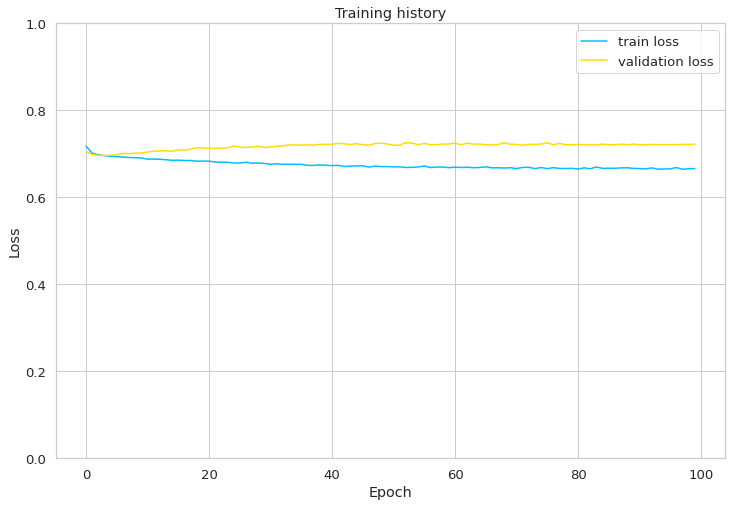

In [ ]:
plot_loss(train_loss=history['train_loss'], val_loss=history['val_loss'])

<h2>Avaliação do Modelo</h2>

Avaliação do modelo treinado. Cálculo da acurácia

In [ ]:
test_loss = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(df_test)
)
test_loss.item()


0.7285568326711654

Função que vai calcular essa acurácia automaticamente

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    with torch.no_grad():
        for d in data_loader:
            
            texts = d["input_text"]
            
            input_ids = d["input_ids"].to(device)
            input_entities_ids = d["input_entities_ids"].to(device)

            attention_mask = d["attention_mask"].to(device)
            attention_entities_mask = d["attention_entities_mask"].to(device)

            targets = d["targets"].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                input_entities_ids=input_entities_ids,
	              attention_entities_mask=attention_entities_mask
              )

            if(device == 'cpu'):
                print('Saída Modelo: ' + str(outputs.detach().numpy()) + '\nPredição 0/1: ' + str([1 if x.item(0) >= 0.5 else 0 for x in outputs.detach().numpy()]) + str('\nValor Real: ' + str(targets)))
                preds = torch.tensor([1 if x.item(0) >= 0.5 else 0 for x in outputs.detach().numpy()])
            else:
                print('Saída Modelo: ' + str(outputs.cpu().detach().numpy()) + '\nPredição 0/1: ' + str([1 if x.item(0) >= 0.5 else 0 for x in outputs.cpu().detach().numpy()]) + str('\nValor Real: ' + str(targets)))
                preds = torch.tensor([1 if x.item(0) >= 0.5 else 0 for x in outputs.cpu().detach().numpy()]).to(device)

            print('Acertos: ' + str(preds == targets))
            print('Acertos sumarizados: ' + str(torch.sum(preds == targets)))
            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)
    
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
  
    return review_texts, predictions, prediction_probs, real_values

<h3>Chamada da Função para calcular as predições</h3>

Semelhante à função de avaliação, exceto que estamos armazenando o texto das sentenças e as probabilidades previstas

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

Saída Modelo: [[0.00400736]
 [0.00800742]
 [0.02018184]
 [0.01171237]
 [0.00369949]
 [0.00386916]
 [0.00325941]
 [0.00544612]
 [0.08715869]
 [0.00702078]
 [0.00869314]
 [0.8377241 ]
 [0.83039117]
 [0.9535775 ]
 [0.52559525]
 [0.85535043]]
Predição 0/1: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
Valor Real: tensor([0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1], device='cuda:0')
Acertos: tensor([ True,  True, False,  True, False,  True,  True,  True,  True, False,
         True,  True, False,  True,  True,  True], device='cuda:0')
Acertos sumarizados: tensor(12, device='cuda:0')
Saída Modelo: [[0.9392387 ]
 [0.01337348]
 [0.00524925]
 [0.00924848]
 [0.00434264]
 [0.00581152]
 [0.00635258]
 [0.00332794]
 [0.00877251]
 [0.1411193 ]
 [0.01273087]
 [0.0915941 ]
 [0.00604884]
 [0.013472  ]
 [0.8739269 ]
 [0.8527657 ]]
Predição 0/1: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
Valor Real: tensor([1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Acertos: tensor([ Tr

<h3>Relatório da Classificação</h3>

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

<h3>Matriz de Confusão</h3>

In [ ]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('Classificação Real')
    plt.xlabel('Classificação Predita');
    
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

show_confusion_matrix(df_cm)

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test

([('Na manhã de segunda-feira 13/07, foi realizado o lançamento do Plano Safra do Banco do Brasil 2020/2021 no Rio Grande do Sul, que disponibilizará R$ 14 bilhões para o Estado, sendo a distribuição de R$ 11,6 bilhões em custeio, comercialização e industrialização; R$ 1,4 bilhão para investimentos e R$ 1 bilhão para outras finalidades.',
   'O PagSeguro lançou em maio uma conta digital grátis chamada PagBank para disputar espaço com o Nubank e sua NuConta ; no entanto , o serviço dependia de um cartão Mastercard que custava R$ 12,9 0 para ser emitido .',
   'Redes como D’Avó, de São Paulo, e Super Lagoa, no Nordeste, já oferecem aos clientes a opção de eles sacarem dinheiro diretamente no caixa.',
   'Banco Hyundai , que terá como sócios a própria montadora sul-coreana e a Aymoré , braço de financiamento pessoal e de veículos do Santander Brasil .',
   "A Resistência Islâmica, ala armada do Hizbollah, apoiada pelo Irã e pela Síria, reivindicou o ataque em um comunicado em que disse qu

([('Na manhã de segunda-feira 13/07, foi realizado o lançamento do Plano Safra do Banco do Brasil 2020/2021 no Rio Grande do Sul, que disponibilizará R$ 14 bilhões para o Estado, sendo a distribuição de R$ 11,6 bilhões em custeio, comercialização e industrialização; R$ 1,4 bilhão para investimentos e R$ 1 bilhão para outras finalidades.',
   'O PagSeguro lançou em maio uma conta digital grátis chamada PagBank para disputar espaço com o Nubank e sua NuConta ; no entanto , o serviço dependia de um cartão Mastercard que custava R$ 12,9 0 para ser emitido .',
   'Redes como D’Avó, de São Paulo, e Super Lagoa, no Nordeste, já oferecem aos clientes a opção de eles sacarem dinheiro diretamente no caixa.',
   'Banco Hyundai , que terá como sócios a própria montadora sul-coreana e a Aymoré , braço de financiamento pessoal e de veículos do Santander Brasil .',
   "A Resistência Islâmica, ala armada do Hizbollah, apoiada pelo Irã e pela Síria, reivindicou o ataque em um comunicado em que disse qu

([('Na manhã de segunda-feira 13/07, foi realizado o lançamento do Plano Safra do Banco do Brasil 2020/2021 no Rio Grande do Sul, que disponibilizará R$ 14 bilhões para o Estado, sendo a distribuição de R$ 11,6 bilhões em custeio, comercialização e industrialização; R$ 1,4 bilhão para investimentos e R$ 1 bilhão para outras finalidades.',
   'O PagSeguro lançou em maio uma conta digital grátis chamada PagBank para disputar espaço com o Nubank e sua NuConta ; no entanto , o serviço dependia de um cartão Mastercard que custava R$ 12,9 0 para ser emitido .',
   'Redes como D’Avó, de São Paulo, e Super Lagoa, no Nordeste, já oferecem aos clientes a opção de eles sacarem dinheiro diretamente no caixa.',
   'Banco Hyundai , que terá como sócios a própria montadora sul-coreana e a Aymoré , braço de financiamento pessoal e de veículos do Santander Brasil .',
   "A Resistência Islâmica, ala armada do Hizbollah, apoiada pelo Irã e pela Síria, reivindicou o ataque em um comunicado em que disse qu

([('Na manhã de segunda-feira 13/07, foi realizado o lançamento do Plano Safra do Banco do Brasil 2020/2021 no Rio Grande do Sul, que disponibilizará R$ 14 bilhões para o Estado, sendo a distribuição de R$ 11,6 bilhões em custeio, comercialização e industrialização; R$ 1,4 bilhão para investimentos e R$ 1 bilhão para outras finalidades.',
   'O PagSeguro lançou em maio uma conta digital grátis chamada PagBank para disputar espaço com o Nubank e sua NuConta ; no entanto , o serviço dependia de um cartão Mastercard que custava R$ 12,9 0 para ser emitido .',
   'Redes como D’Avó, de São Paulo, e Super Lagoa, no Nordeste, já oferecem aos clientes a opção de eles sacarem dinheiro diretamente no caixa.',
   'Banco Hyundai , que terá como sócios a própria montadora sul-coreana e a Aymoré , braço de financiamento pessoal e de veículos do Santander Brasil .',
   "A Resistência Islâmica, ala armada do Hizbollah, apoiada pelo Irã e pela Síria, reivindicou o ataque em um comunicado em que disse qu

([('Na manhã de segunda-feira 13/07, foi realizado o lançamento do Plano Safra do Banco do Brasil 2020/2021 no Rio Grande do Sul, que disponibilizará R$ 14 bilhões para o Estado, sendo a distribuição de R$ 11,6 bilhões em custeio, comercialização e industrialização; R$ 1,4 bilhão para investimentos e R$ 1 bilhão para outras finalidades.',
   'O PagSeguro lançou em maio uma conta digital grátis chamada PagBank para disputar espaço com o Nubank e sua NuConta ; no entanto , o serviço dependia de um cartão Mastercard que custava R$ 12,9 0 para ser emitido .',
   'Redes como D’Avó, de São Paulo, e Super Lagoa, no Nordeste, já oferecem aos clientes a opção de eles sacarem dinheiro diretamente no caixa.',
   'Banco Hyundai , que terá como sócios a própria montadora sul-coreana e a Aymoré , braço de financiamento pessoal e de veículos do Santander Brasil .',
   "A Resistência Islâmica, ala armada do Hizbollah, apoiada pelo Irã e pela Síria, reivindicou o ataque em um comunicado em que disse qu

([('Na manhã de segunda-feira 13/07, foi realizado o lançamento do Plano Safra do Banco do Brasil 2020/2021 no Rio Grande do Sul, que disponibilizará R$ 14 bilhões para o Estado, sendo a distribuição de R$ 11,6 bilhões em custeio, comercialização e industrialização; R$ 1,4 bilhão para investimentos e R$ 1 bilhão para outras finalidades.',
   'O PagSeguro lançou em maio uma conta digital grátis chamada PagBank para disputar espaço com o Nubank e sua NuConta ; no entanto , o serviço dependia de um cartão Mastercard que custava R$ 12,9 0 para ser emitido .',
   'Redes como D’Avó, de São Paulo, e Super Lagoa, no Nordeste, já oferecem aos clientes a opção de eles sacarem dinheiro diretamente no caixa.',
   'Banco Hyundai , que terá como sócios a própria montadora sul-coreana e a Aymoré , braço de financiamento pessoal e de veículos do Santander Brasil .',
   "A Resistência Islâmica, ala armada do Hizbollah, apoiada pelo Irã e pela Síria, reivindicou o ataque em um comunicado em que disse qu